In [3]:
!pip3 install tensorflow_text

     |████████████████████████████████| 4.9 MB 12.0 MB/s 
     |████████████████████████████████| 462 kB 46.6 MB/s 


In [4]:
from google.colab import drive
drive.mount('/content/drive/')
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import numpy as np
import seaborn as sns
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/propaganda/sonal_shyam_icolsi_2021/merged_propaganda_data.csv")
df.head(5)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,text,tag
0,नये कृषि कानूनों को लेकर किसानों के आंदोलन का ...,0
1,इस मामले का हल नहीं निकल पाने के कारण किसानों ...,0
2,आज सुबह यहां टीकरी बॉर्डर पर एक किसान ने आत्मह...,0
3,हरियाणा के जींच से आए किसान कर्मवीर ने फांसी ल...,0
4,इससे किसानों का आक्रोश और बढ़ गया है.,0


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['tag'], stratify=df['tag'])
#X_train, X_test, y_train, y_test = train_test_split(X_train_counts.toarray(),y,test_size=0.1)

In [6]:
X_train.head(5)

6552     नेचर बायो फूड्स की तरह सनस्टार और अन्य कंपनिया...
7437                        यह परंपरा सालों से बनी हुई थी.
6929     लोग अपने अपने अंदाज में किसानों के समर्थन में ...
9096     जलंधर के निकट एक दूसरे किसान ने बताया था कि पर...
15578    संगठन पदाधिकारियों ने विरोध करते हुए कहा कि सर...
Name: text, dtype: object

In [10]:
#y_train.value_counts()

In [11]:
#y_test.value_counts()

In [12]:
#91/1161

In [13]:
#bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
#bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [7]:
# earlier it was bert which is not pretrained on hindi, later MuRIL is trained but variable name are same as bert 

bert_preprocess = hub.KerasLayer('https://tfhub.dev/google/MuRIL_preprocess/1')
bert_encoder = hub.KerasLayer( 'https://tfhub.dev/google/MuRIL/1')

In [8]:
def get_sentence_embedding(sentences):
  preprocessed_text = bert_preprocess(sentences)
  return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embedding([
                        "मुझे जाने दो ।",
                        "पिछले हफते वह दिल्ली जा चुका था ।"
])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[ 0.0091266 ,  0.01873379, -0.00757235, ..., -0.0203275 ,
        -0.01011931, -0.0118993 ],
       [ 0.00914075,  0.01904471, -0.00725823, ..., -0.02047424,
        -0.00980483, -0.01157611]], dtype=float32)>

In [9]:
e = get_sentence_embedding([
                        "केला",
                        "अंगूर",
                        "आम",
                        "जेफ बेजोस",
                        "इलोन मस्क",
                        "बिल गेटस"
])

In [17]:
e

<tf.Tensor: shape=(6, 768), dtype=float32, numpy=
array([[ 0.0088844 ,  0.01819715, -0.00822748, ..., -0.02123349,
        -0.01116486, -0.01195889],
       [ 0.00971548,  0.01812792, -0.00822459, ..., -0.02088753,
        -0.01020589, -0.01186351],
       [ 0.00958711,  0.01828854, -0.00802168, ..., -0.02106201,
        -0.01043706, -0.01206129],
       [ 0.00935569,  0.01888775, -0.00818696, ..., -0.02082656,
        -0.01025233, -0.01222294],
       [ 0.00908101,  0.01920624, -0.00724612, ..., -0.02041258,
        -0.01068481, -0.01145445],
       [ 0.00935705,  0.01838987, -0.0077011 , ..., -0.02124736,
        -0.0092931 , -0.01161574]], dtype=float32)>

In [10]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[4]])

array([[0.9978697]], dtype=float32)

In [11]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

first = tf.keras.layers.Dropout(0.1, name='dropout')(outputs['pooled_output'])
first = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(first)

model = tf.keras.Model(inputs=[text_input], outputs=[first])


In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [21]:
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')

]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [22]:
model.fit(X_train, y_train, epochs=2)

Epoch 1/2
526/526 [==============================] - 373s 685ms/step - loss: 0.3864 - accuracy: 0.9090 - precision: 0.0833 - recall: 6.5703e-04
Epoch 2/2
526/526 [==============================] - 362s 688ms/step - loss: 0.3043 - accuracy: 0.9095 - precision: 0.0000e+00 - recall: 0.0000e+00


In [23]:
model.evaluate(X_test, y_test)

176/176 [==============================] - 120s 674ms/step - loss: 0.3038 - accuracy: 0.9094 - precision: 0.0000e+00 - recall: 0.0000e+00


[0.3038437068462372, 0.9094312787055969, 0.0, 0.0]

In [24]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [25]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 0, ..., 0, 0, 0])

In [26]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_predicted)
cm 

array([[5101,    0],
       [ 508,    0]])

Text(33.0, 0.5, 'Truth')

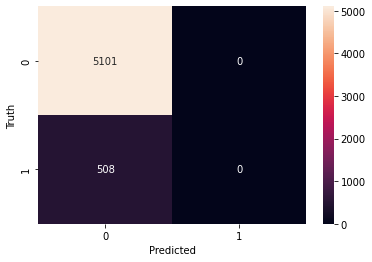

In [27]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [28]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      5101
           1       0.00      0.00      0.00       508

    accuracy                           0.91      5609
   macro avg       0.45      0.50      0.48      5609
weighted avg       0.83      0.91      0.87      5609



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
text = [
        'राम गाना गा रहा है'
        
        ]
model.predict(text)

array([[0.5037617]], dtype=float32)